In [1]:
#importing the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
#reading the dataset
dfSub = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')
dfStarter = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
dfTrain = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
dfTest = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

In [3]:
#Making a Copy of The Dataset
#I would be working with this copy through out the project while the original dataframe would be for referencing when needed .
df_Sub = dfSub.copy()
df_Starter = dfStarter.copy()
df_Train = dfTrain.copy()
df_Test =dfTest.copy()

In [4]:
#checking out number of rows and columns of each dataset
print(df_Train.shape)
print(df_Test.shape)
print(df_Sub.shape)
print(df_Starter.shape)

(122265, 7)
(25080, 3)
(25080, 2)
(3142, 26)


Along with the row id, cfips, county, and state, first day of month, microbusiness density, and active fields are included in `train data`. 

Only row id, cfips, and first day of month are present in the `test data`. 

Microbusiness density for a specific cfips and at a specific first day of month is the value to be predicted.

In [5]:
#information on the test dataset
df_Test.head(3)

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01


In [6]:
#unique dates in test dataset
df_Test.first_day_of_month.unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

Test dataset spans from, November 2022 through June 2023.

In [7]:
print('The minimum date given for the train dataset:', df_Test['first_day_of_month'].min())
print('The maximum date given for the train dataset:', df_Test['first_day_of_month'].max())

The minimum date given for the train dataset: 2022-11-01
The maximum date given for the train dataset: 2023-06-01


In [8]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [9]:
#information on train datset
df_Train.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198


In [10]:
df_Train.first_day_of_month.unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01'], dtype=object)

Train dataset spans from August 2019 through October 2022.

In [11]:
print('The number of states:', df_Train['state'].nunique())
print('The minimum date given for the train dataset:',  df_Train['first_day_of_month'].min())
print('The maximum date given for the train dataset:',  df_Train['first_day_of_month'].max())

The number of states: 51
The minimum date given for the train dataset: 2019-08-01
The maximum date given for the train dataset: 2022-10-01


## What number of cfips are there?
Let's now investigate the cfips data.

In [12]:
df_Train['cfips'].nunique(), df_Test['cfips'].nunique(), df_Starter['cfips'].nunique()

(3135, 3135, 3142)

We have test and train data totaling 3135 cfips.
There are 3142 cfips overall (according to census statistics).
The train and test datasets do not contain all of the cfips for which we do have census data.

## Data Cleaning

In [13]:
#function to seperate the first day of the month from the cfips
def get_first_day_of_month(item):
    item = item.split('_')[1]
    return item

def get_cfips(item):
    item = item.split('_')[0]
    return item

In [14]:
#applying the defined function
df_Sub['first_day_of_month'] = df_Sub['row_id'].apply(get_first_day_of_month)
df_Sub['cfips'] = df_Sub['row_id'].apply(get_cfips)

In [15]:
#converting the date to datetime
df_Test['first_day_of_month'] = pd.to_datetime(df_Test['first_day_of_month'])
df_Train['first_day_of_month'] = pd.to_datetime(df_Train['first_day_of_month'])
df_Sub['first_day_of_month'] = pd.to_datetime(df_Sub['first_day_of_month'])

In [16]:
# train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
# train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

df_Train['year'] = df_Train['first_day_of_month'].dt.year
df_Train['month'] = df_Train['first_day_of_month'].dt.month

In [17]:
#dropping the `row_id` column
df_Test.drop(['row_id'],axis = 1, inplace = True)
df_Train.drop(['row_id'],axis = 1, inplace = True)
df_Sub.drop(['row_id'],axis = 1, inplace = True)

In [18]:
#merging the dataset 
df_trainMerged = df_Train.merge(df_Starter, on = 'cfips', how = 'left')
df_trainMerged.head(2)

,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_bb_2017,pct_bb_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,76.6,78.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,76.6,78.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0


In [19]:
#after merging, we can see that some columns now have null values which needs to be cleaned up
df_trainMerged.isna().sum()

cfips                     0
county                    0
state                     0
first_day_of_month        0
microbusiness_density     0
active                    0
year                      0
month                     0
pct_bb_2017               0
pct_bb_2018               0
pct_bb_2019               0
pct_bb_2020               0
pct_bb_2021               0
pct_college_2017          0
pct_college_2018          0
pct_college_2019          0
pct_college_2020          0
pct_college_2021          0
pct_foreign_born_2017     0
pct_foreign_born_2018     0
pct_foreign_born_2019     0
pct_foreign_born_2020     0
pct_foreign_born_2021     0
pct_it_workers_2017       0
pct_it_workers_2018      39
pct_it_workers_2019       0
pct_it_workers_2020       0
pct_it_workers_2021       0
median_hh_inc_2017        0
median_hh_inc_2018       39
median_hh_inc_2019        0
median_hh_inc_2020       39
median_hh_inc_2021       39
dtype: int64

In [20]:
#sample is the df_trainMerged['pct_bb_2018']column which we can also view below
df_null = df_trainMerged[df_trainMerged['pct_it_workers_2018'].isnull()]
df_null.head(2)

,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_bb_2017,pct_bb_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
70707,35039,Rio Arriba County,New Mexico,2019-08-01,2.472180,742,2019,8,49.1,52.1,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0
70708,35039,Rio Arriba County,New Mexico,2019-09-01,2.458852,738,2019,9,49.1,52.1,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0


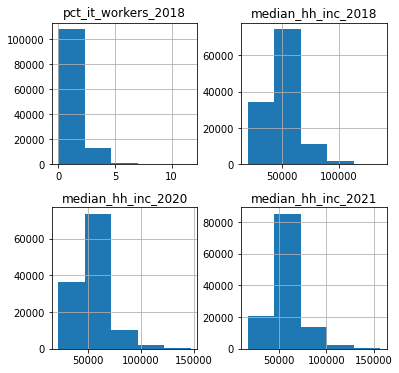

In [21]:
data1 = df_trainMerged[['pct_it_workers_2018','median_hh_inc_2018', 'median_hh_inc_2020', 'median_hh_inc_2021']]
data1.hist(bins = 5, figsize=(6,6))
plt.show()

The null columns are skewed to the left they are also numerical, therfore, I would be  using the median value for replacing the missing values.


In [22]:
#filling the null values with the median
df_trainMerged['pct_it_workers_2018']= df_trainMerged['pct_it_workers_2018'].fillna(df_trainMerged['pct_it_workers_2018'].median())
df_trainMerged['median_hh_inc_2018']= df_trainMerged['median_hh_inc_2018'].fillna(df_trainMerged['median_hh_inc_2018'].median())
df_trainMerged['median_hh_inc_2020']= df_trainMerged['median_hh_inc_2020'].fillna(df_trainMerged['median_hh_inc_2020'].median())
df_trainMerged['median_hh_inc_2021']= df_trainMerged['median_hh_inc_2021'].fillna(df_trainMerged['median_hh_inc_2021'].median())

## Exploratory Data Analysis

### The top 10 counties according to their counts

In [23]:
#grouping the country based on their count in a descending order
top_county = df_trainMerged['county'].groupby(df_trainMerged['county']).size().sort_values(ascending = False)
top_county = top_county.reset_index(name='counts')
top_county.head(10)

,county,counts
0,Washington County,1170
1,Jefferson County,975
2,Franklin County,936
3,Lincoln County,897
4,Jackson County,897
5,Madison County,741
6,Montgomery County,702
7,Clay County,702
8,Marion County,663
9,Monroe County,663


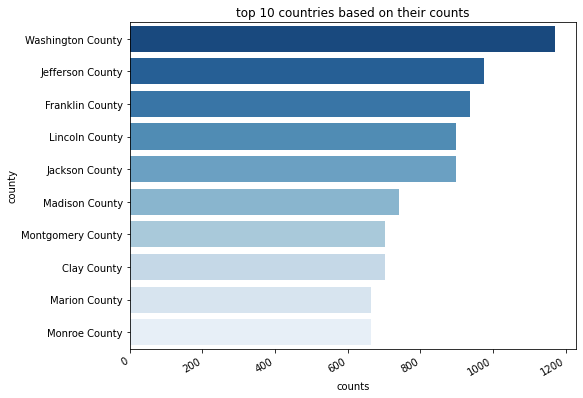

In [24]:
plt.figure(figsize = (8,6))
sns.barplot(y ='county', x = 'counts', data = top_county.head(10), linewidth = 2,  palette ='Blues_r' )
plt.xticks(rotation = 30, ha='right')
plt.title('top 10 countries based on their counts')
plt.show()

### The top 10 county based on their microdensities

In [25]:
top_countyM = df_trainMerged.groupby('county')['microbusiness_density'].mean().sort_values(ascending=False)
top_countyM = top_countyM.reset_index()
top_countyM.head(10)

,county,microbusiness_density
0,Carson City,87.196625
1,Rio Grande County,60.942899
2,Boundary County,46.730638
3,New York County,32.892037
4,Minnehaha County,32.261295
5,Transylvania County,28.956531
6,Pitkin County,27.567022
7,Falls Church city,22.216376
8,Tulsa County,22.156203
9,Alachua County,21.545587


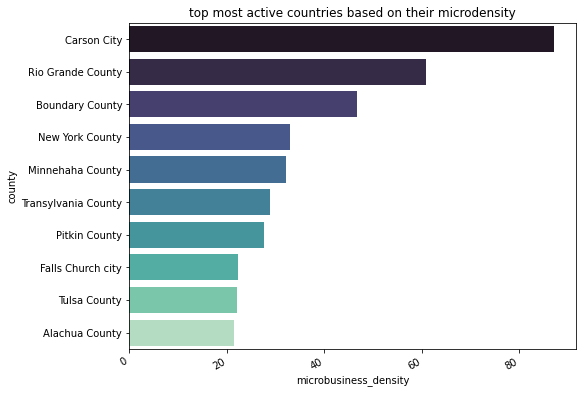

In [26]:
#average microdensitiy countries plot
plt.figure(figsize = (8,6))
sns.barplot(data = top_countyM.head(10), y = 'county', x = 'microbusiness_density', linewidth = 2,  palette ='mako')
plt.xticks(rotation = 30, ha='right')
plt.title('top most active countries based on their microdensity')
plt.show()

### The top counties with most active microbusinesses

In [27]:
#average microdensitiy countries plot
active_countyM =  df_trainMerged.groupby('county')['active'].sum().sort_values(ascending=False)
active_countyM = active_countyM.reset_index()
active_countyM.head(10)

,county,active
0,Los Angeles County,43842767
1,Orange County,23266851
2,Maricopa County,18238217
3,New York County,17943980
4,Clark County,15827161
5,San Diego County,14132392
6,Cook County,13971074
7,Miami-Dade County,13859930
8,Montgomery County,12313737
9,Harris County,11642363


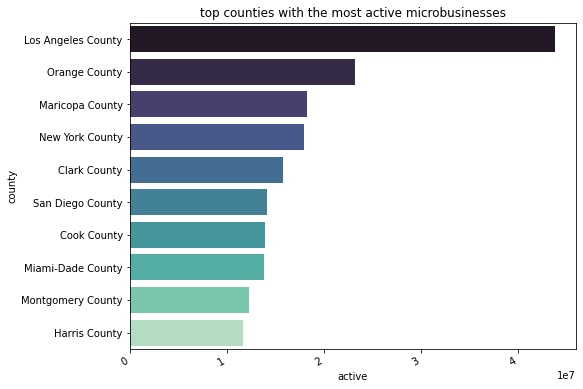

In [28]:
#average microdensitiy countries plot
plt.figure(figsize = (8,6))
sns.barplot(data = active_countyM.head(10), y = 'county', x='active', linewidth = 2,  palette ='mako')
plt.xticks(rotation = 30, ha='right')
plt.title('top counties with the most active microbusinesses')
plt.show()